# **Lab 9.1 Generative Adversarial Network**
**NOTE :** Use the dataset from lab5.

In [1]:
import torch
from torch import nn
from tqdm import tqdm
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision.utils import make_grid, save_image
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np
import os
import torch.optim as optim

## Architecture
Complete the GAN architecture that generates RGB images of size 128x128.

In [2]:
### START CODE HERE ###
# Generator Network
class Generator(nn.Module):
    def __init__(self, z_dim=100, channels_img=3, features_g=64):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            self._block(z_dim, features_g * 16, 4, 1, 0),  # 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # 32x32
            self._block(features_g * 2, features_g, 4, 2, 1),  # 64x64
            nn.ConvTranspose2d(
                features_g, channels_img, kernel_size=4, stride=2, padding=1
            ),
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

### END CODE HERE ###

In [3]:
### START CODE HERE ###
# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self, channels_img=3, features_d=64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(channels_img, features_d, 4, 2, 1),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            self._block(features_d * 8, features_d * 16, 4, 2, 1),
            nn.Conv2d(features_d * 16, 1, 4, 2, 0),
            nn.Sigmoid(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)
### END CODE HERE ###

Complete the function below. The `get_noise` function generates a random noise tensor that is typically used as input to a Generator
- `n_sample`: The number of noise samples to generate.

- `z_dim`: The dimensionality of each noise vector.

- `device`: The device on which the tensor will be allocated. By default, it is set to 'cuda'

In [4]:
### START CODE HERE ###
def get_noise(n_sample, z_dim, device='cuda'):
    return torch.randn(n_sample, z_dim, device=device)

# Initialize weights
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

def test():
    N, in_channels, H, W = 8, 3, 128, 128  # Updated to 128x128
    z_dim = 100
    x = torch.randn((N, in_channels, H, W))
    
    # Test Discriminator
    disc = Discriminator(in_channels, 8)  # Discriminator input should match 128x128 image
    assert disc(x).shape == (N, 1, 1, 1), "Discriminator test failed"
    
    # Test Generator
    gen = Generator(z_dim, in_channels, 8)  # Generator output should be 128x128
    z = torch.randn((N, z_dim, 1, 1))
    assert gen(z).shape == (N, in_channels, H, W), "Generator test failed"
    
    print("Success, tests passed!")

test()

### END CODE HERE ###

Success, tests passed!


In [5]:
n_sample = 25
z_dim = 100
noise = get_noise(n_sample, z_dim)
assert noise.shape == (n_sample, z_dim), f"Expected shape {(n_sample, z_dim)}, but got {noise.shape}"

noise_cpu = get_noise(n_sample, z_dim, device='cpu')
assert noise_cpu.device.type == 'cpu', f"Expected tensor to be on 'cpu', but got {noise_cpu.device.type}"
assert noise.dtype == torch.float32, f"Expected dtype to be torch.float32, but got {noise.dtype}"

## Preparation
Prepare all training components such as the dataset, batch size, optimizer, and model, etc. No need to perform a train-test split.

In [6]:
### START CODE HERE ###

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
IMAGE_SIZE = 128
CHANNELS_IMG = 3


Transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
dataset = datasets.ImageFolder(root="data", transform=Transforms)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


### END CODE HERE ###

Display first batch of dataset.

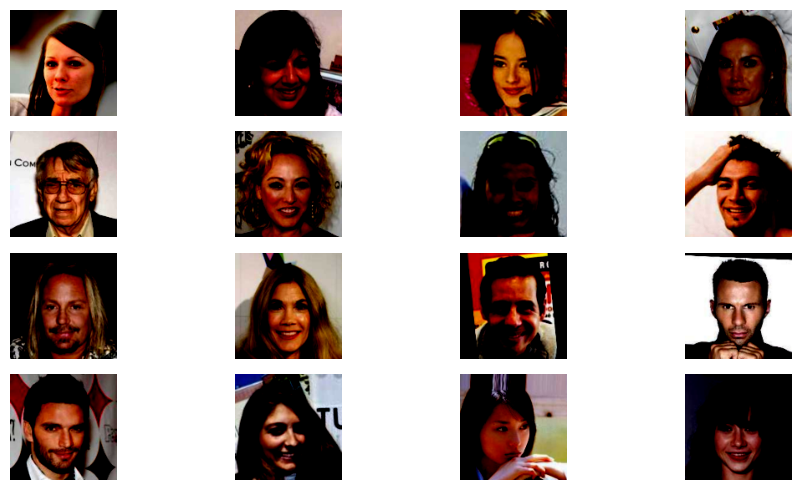

In [7]:
### START CODE HERE ###
def imshow_grid(images):
    fig = plt.figure(figsize=(10, 5))
    num_images = len(images)
    grid_size = int(np.ceil(np.sqrt(num_images)))
    
    for i in range(num_images):
        a = fig.add_subplot(grid_size, grid_size, i + 1)
        img = np.transpose(images[i], (1, 2, 0))
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        
        a.axis("off")
    
    plt.tight_layout()
    plt.show()
batch, _ = next(iter(dataloader)) 
imshow_grid(batch)

### END CODE HERE ###

Use `get_noise` to generate noise with 25 samples, and then use the generator to generate images with that noise.
<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://github.com/Digital-Image-Processing-Laboratory/image_processing-2024/blob/master/Lab9_GAN/assets/1.png?raw=true)


</details>

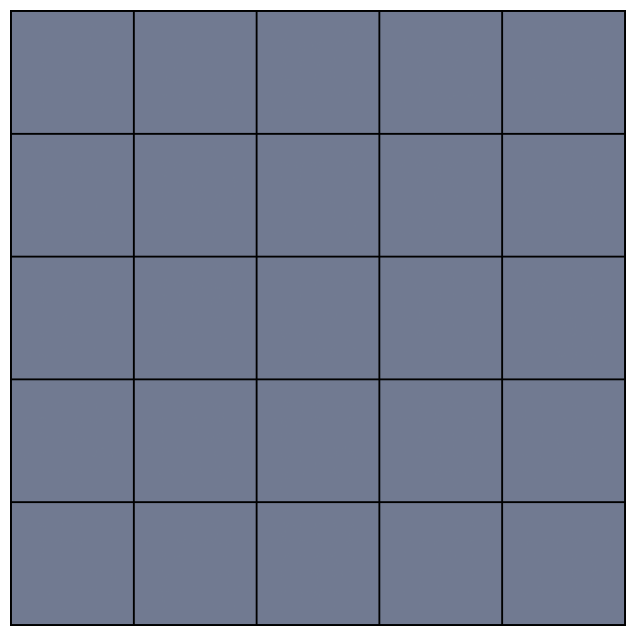

In [8]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

### START CODE HERE ###
# Ensure the generator is in evaluation mode
# Initialize the Generator
z_dim = 256
generator = Generator(z_dim=z_dim)

# If you have a trained model, load its state dict here
# generator.load_state_dict(torch.load('path_to_your_model.pth'))

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = generator.to(device)

# Generate noise
n_samples = 25  # Number of samples (images) to generate
noise = get_noise(n_samples, z_dim, device=device).view(n_samples, z_dim, 1, 1)  # Reshape to [n_samples, z_dim, 1, 1]

# Generate images
generator.eval()  # Set the generator to evaluation mode
with torch.no_grad():
    fake_images = generator(noise).cpu()  # Move the generated images to the CPU

# Function to rescale images from [-1, 1] to [0, 1]
def rescale_image(image_tensor):
    return (image_tensor + 1) / 2

# Rescale images for display
fake_images = rescale_image(fake_images)

# Function to display images in a grid
def imshow_grid(images, nrow=5):
    """Display images in a grid."""
    grid_img = make_grid(images, nrow=nrow, padding=2, normalize=False)  # Create a grid of images
    plt.figure(figsize=(8, 8))
    plt.imshow(grid_img.permute(1, 2, 0).numpy())  # Permute dimensions for correct display
    plt.axis('off')
    plt.show()

# Display the generated images in a 5x5 grid
imshow_grid(fake_images, nrow=5)
### END CODE HERE ###


Complete the training function that trains and logs the average loss for both the generator and discriminator, and generates sample images at each epoch (using the same input vector as the previous part) to [TensorBoard](https://pytorch.org/docs/stable/tensorboard.html).
<details>
<summary>
<font size="3" color="orange">
<b>Expected output in tensorboard</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://github.com/Digital-Image-Processing-Laboratory/image_processing-2024/blob/master/Lab9_GAN/assets/2.png?raw=true)


</details>


In [9]:
### START CODE HERE ###
# Training function
def train(dataloader, gen, disc, opt_gen, opt_disc, criterion, fixed_noise, num_epochs, device, save_dir):
    writer_real = SummaryWriter(f"{save_dir}/logs/real")
    writer_fake = SummaryWriter(f"{save_dir}/logs/fake")
    step = 0
    Z_DIM = 100
    for epoch in range(num_epochs):
        for batch_idx, (real, _) in enumerate(dataloader):
            real = real.to(device)
            batch_size = real.shape[0]
            noise = torch.randn(batch_size, Z_DIM, 1, 1).to(device)
            
            # Train Discriminator
            disc.zero_grad()
            fake = gen(noise)
            disc_real = disc(real).reshape(-1)
            disc_fake = disc(fake.detach()).reshape(-1)
            loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
            loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
            loss_disc = (loss_disc_real + loss_disc_fake) / 2
            loss_disc.backward()
            opt_disc.step()

            # Train Generator
            gen.zero_grad()
            output = disc(fake).reshape(-1)
            loss_gen = criterion(output, torch.ones_like(output))
            loss_gen.backward()
            opt_gen.step()

            # Print progress
            if batch_idx % 100 == 0:
                print(
                    f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(dataloader)} "
                    f"Loss D: {loss_disc:.4f}, Loss G: {loss_gen:.4f}"
                )

                with torch.no_grad():
                    fake = gen(fixed_noise)
                    img_grid_real = make_grid(real[:32], normalize=True)
                    img_grid_fake = make_grid(fake[:32], normalize=True)
                    writer_real.add_image("Real", img_grid_real, global_step=step)
                    writer_fake.add_image("Fake", img_grid_fake, global_step=step)
                    
                    # Save sample images
                    save_image(fake[:25], f"{save_dir}/samples/fake_{epoch}_{batch_idx}.png",
                             normalize=True, nrow=5)
                step += 1

        # Save model checkpoint
        torch.save({
            'generator_state_dict': gen.state_dict(),
            'discriminator_state_dict': disc.state_dict(),
            'gen_optimizer_state_dict': opt_gen.state_dict(),
            'disc_optimizer_state_dict': opt_disc.state_dict(),
        }, f"{save_dir}/checkpoints/checkpoint_epoch_{epoch}.pth")

### END CODE HERE ###

In [10]:
### START CODE HERE ###
# Hyperparameters etc.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 2e-4
BATCH_SIZE = 128
IMAGE_SIZE = 128
CHANNELS_IMG = 3
Z_DIM = 100
NUM_EPOCHS = 2
FEATURES_D = 64
FEATURES_G = 64

# Directory setup
DATA_DIR = "data"  # Change this to your dataset directory
SAVE_DIR = "results"
os.makedirs(f"{SAVE_DIR}/checkpoints", exist_ok=True)
os.makedirs(f"{SAVE_DIR}/samples", exist_ok=True)
os.makedirs(f"{SAVE_DIR}/logs", exist_ok=True)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data preprocessing
Transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Dataset and dataloader
dataset = datasets.ImageFolder(root=DATA_DIR, transform=Transforms)
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

# Initialize networks
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_G).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_D).to(device)
initialize_weights(gen)
initialize_weights(disc)

# Optimizers
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()

# Fixed noise for visualization
fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)

# Train the model
train(dataloader, gen, disc, opt_gen, opt_disc, criterion, fixed_noise, 
        NUM_EPOCHS, device, SAVE_DIR)
## END CODE HERE ###

Using device: cuda


Test Genereate the image.
<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://github.com/Digital-Image-Processing-Laboratory/image_processing-2024/blob/master/Lab9_GAN/assets/3.png?raw=true)


</details>

C:\Users\sitth\AppData\Local\Temp\ipykernel_19848\112504440.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device

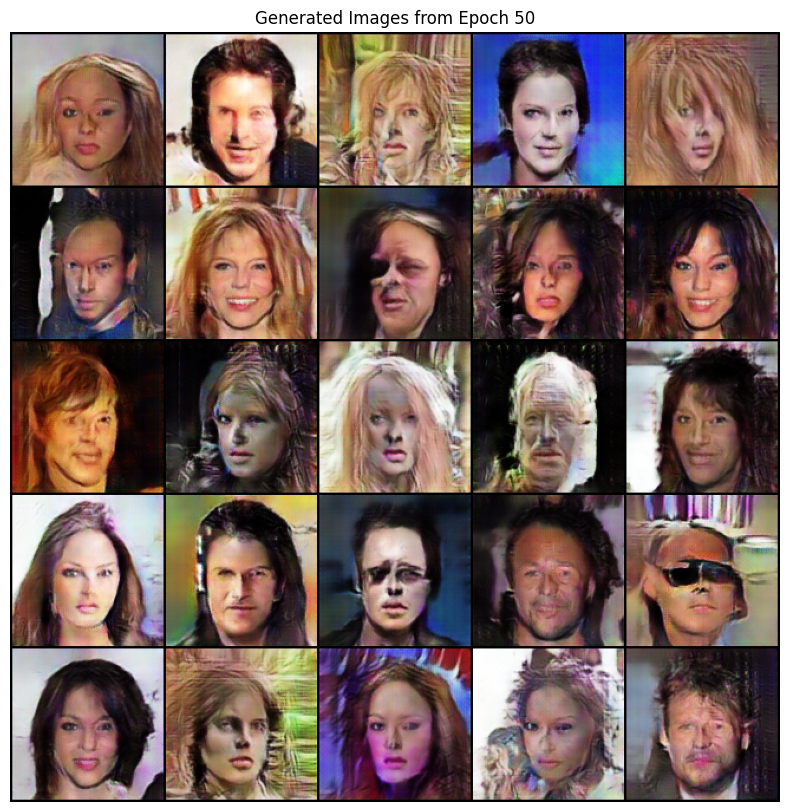

tensor([[[[0.7160, 0.6671, 0.6639,  ..., 0.4836, 0.5309, 0.5516],
          [0.6857, 0.6836, 0.6876,  ..., 0.4847, 0.4790, 0.4979],
          [0.6910, 0.6672, 0.6874,  ..., 0.4913, 0.5085, 0.4821],
          ...,
          [0.6520, 0.6806, 0.6776,  ..., 0.4725, 0.3226, 0.3217],
          [0.5773, 0.6034, 0.6321,  ..., 0.3511, 0.3328, 0.3124],
          [0.5312, 0.6026, 0.6279,  ..., 0.3247, 0.2928, 0.2968]],

         [[0.7114, 0.6979, 0.7233,  ..., 0.4886, 0.5199, 0.5378],
          [0.7319, 0.7058, 0.6967,  ..., 0.4917, 0.4554, 0.4854],
          [0.7424, 0.7182, 0.6937,  ..., 0.4767, 0.4508, 0.4785],
          ...,
          [0.4608, 0.5147, 0.5112,  ..., 0.2735, 0.1966, 0.1971],
          [0.4092, 0.4190, 0.4593,  ..., 0.1984, 0.1837, 0.1878],
          [0.4241, 0.4222, 0.4379,  ..., 0.2321, 0.1759, 0.1980]],

         [[0.7641, 0.7333, 0.7802,  ..., 0.6151, 0.6244, 0.6435],
          [0.7372, 0.7317, 0.7328,  ..., 0.6120, 0.6278, 0.6278],
          [0.7328, 0.7051, 0.7739,  ..., 0

In [11]:
### START CODE HERE ###
def load_and_display(epoch_num, num_images=25, z_dim=100, checkpoint_dir="results/checkpoints"):
    # Set up device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Initialize the generator
    gen = Generator(z_dim=z_dim).to(device)
    
    # Construct checkpoint path
    checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch_num}.pth")
    
    # Check if checkpoint exists
    if not os.path.exists(checkpoint_path):
        print(f"No checkpoint found for epoch {epoch_num}")
        return
    
    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    gen.load_state_dict(checkpoint['generator_state_dict'])
    
    # Generate images
    gen.eval()
    with torch.no_grad():
        # Create random noise
        noise = torch.randn(num_images, z_dim, 1, 1).to(device)
        # Generate images
        fake_images = gen(noise)
        # Denormalize
        fake_images = (fake_images + 1) / 2
    
    # Display images
    grid = make_grid(fake_images.cpu(), nrow=5, normalize=False)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.title(f'Generated Images from Epoch {epoch_num}')
    plt.show()
    
    return fake_images.cpu()  # Return the generated images if needed

EPOCH_TO_DISPLAY = 50  # Change this to whatever epoch you want to see
    
# Load and display images from that epoch
load_and_display(
    epoch_num=EPOCH_TO_DISPLAY,
    num_images=25,  # Number of images to generate
    z_dim=100,  # Should match your training configuration
    checkpoint_dir="results/checkpoints"  # Path to your checkpoints
)
### END CODE HERE ###

---

# Question
1. In the architecture of a discriminator, if the last layer is not a fully connected layer and the output is in a 3D tensor format rather than a 1D vector, how would you compute the Binary Cross-Entropy Loss (BCELoss) in this case?

2. If the architecture of the generator includes one or more hidden fully connected layers before the output layer, how would this affect the quality or characteristics of the generated output? 

3. When alternating between training the generator and the discriminator in a GAN, at which level should this switching occur to achieve optimal results—should it be done at the epoch level, the iteration level, or the batch level?

# ตอบคำถามท้ายการทดลอง 9.1
1. In the architecture of a discriminator, if the last layer is not a fully connected layer and the output is in a 3D tensor format rather than a 1D vector, how would you compute the Binary Cross-Entropy Loss (BCELoss) in this case?

    ans:
    
    Flatten the Output: แปลง output 3D tensor จาก discriminator ให้เป็น 1D vector

    Flatten the Target Labels: ตรวจสอบให้แน่ใจว่า target labels อยู่ในรูปแบบที่เข้ากันได้ โดยทั่วไปจะเป็น tensor 1D ที่มีความยาวเท่ากับ output ที่ Flatten
---

2. If the architecture of the generator includes one or more hidden fully connected layers before the output layer, how would this affect the quality or characteristics of the generated output? 

    ans:

    Increased Capacity: Hidden layers ช่วยเพิ่มความสามารถของโมเดลในการเรียนรู้การแมพจาก noise ไปยังการแจกแจงข้อมูล ซึ่งอาจนำไปสู่ output ที่มีคุณภาพสูงขึ้น

    Better Feature Representation: Layers เหล่านี้ช่วยให้การแทนค่าฟีเจอร์ดีขึ้น ทำให้ generator สามารถจับคู่รูปแบบที่ซับซ้อนในข้อมูลฝึกได้

    Risk of Overfitting: แม้ว่า layers เพิ่มเติมจะช่วยปรับปรุงประสิทธิภาพ แต่ก็เพิ่มความเสี่ยงของ overfitting โดยเฉพาะหากไม่ได้จัดการอย่างเหมาะสมด้วยเทคนิคต่างๆ เช่น dropout หรือ batch normalization
        
    Training Stability: การมี hidden layers หากไม่สมดุลกับความสามารถของ discriminator หาก discriminator เก่งเร็วเกินไป อาจนำไปสู่ปัญหา vanishing gradients สำหรับ generator
---
3. When alternating between training the generator and the discriminator in a GAN, at which level should this switching occur to achieve optimal results—should it be done at the epoch level, the iteration level, or the batch level?

    ans:

    Dynamic Adjustment: การสลับในแต่ละ iteration ช่วยให้สามารถปรับเปลี่ยนได้ตาม feed back จากทั้งสองฝั่ง ทำให้การ train มีความสมดุลมากขึ้น

    Avoiding Mode Collapse: การอัปเดตบ่อยๆ ช่วยป้องกันสถานการณ์ที่ฝั่งใดฝั่งหนึ่งเก่งเกินไป

    *แบบไหนดี ระหว่าง batch, iteration, epoch

    ระดับ batch: เทรน Discriminator หนึ่ง batch จากนั้นเทรน Generator หนึ่งแบตช์ และทำซ้ำ วิธีนี้ให้ความสมดุลที่ดีและช่วยรักษาความเสถียร

    ระดับ iteration: เทรน Discriminator k รอบ จากนั้นเทรน Generator หนึ่งรอบ วิธีนี้ใช้ใน GAN บางรูปแบบ เช่น WGAN

    ระดับ epoch: เทรนโมเดลเต็ม epoch 1 รอบก่อนที่จะสลับ วิธีนี้อาจทำให้โมเดลเกิด overfitting ก่อนที่อีกโมเดลจะมีโอกาสปรับปรุง
---

        